# Test: Multiple Counties
* Find where providers don't have service in several counties before applying functions to the entire state.

In [16]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import utilities
from calitp import *
from shared_utils import geography_utils
from shared_utils import utils 
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

In [3]:
ca_counties = utilities.get_counties()

In [4]:
# Replace spaces with _ 
ca_counties['county_name'] = ca_counties['county_name'].str.replace(' ','_')

In [5]:
# Read in ATT
att = dg.read_parquet("ATT.parquet")

## Test with Districts

In [6]:
Caltrans_shape = "https://gis.data.ca.gov/datasets/0144574f750f4ccc88749004aca6eb0c_0.geojson?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
ct_districts = to_snakecase(gpd.read_file(f'{Caltrans_shape}')
               .to_crs(epsg=4326))[['district','geometry']]

In [7]:
my_list = list(range(1, 13))

In [8]:
my_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [40]:
def breakout_districts():
    # Load geojson 
    caltrans_shape = "https://gis.data.ca.gov/datasets/0144574f750f4ccc88749004aca6eb0c_0.geojson?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
    ct_districts = to_snakecase(gpd.read_file(f'{caltrans_shape}')
               .to_crs(epsg=4326))[['district','geometry']]
    
    # Districts: subset
    district_list = [10,4]
    
    full_gdf = pd.DataFrame()

    for i in district_list:
        district_gdf = ct_districts[ct_districts.district==i]
        
        full_gdf = pd.concat([full_gdf, district_gdf], axis=0)
        
    full_gdf = full_gdf.dissolve().drop(columns = ['district'])

    return full_gdf

In [41]:
test = breakout_districts()

<AxesSubplot:>

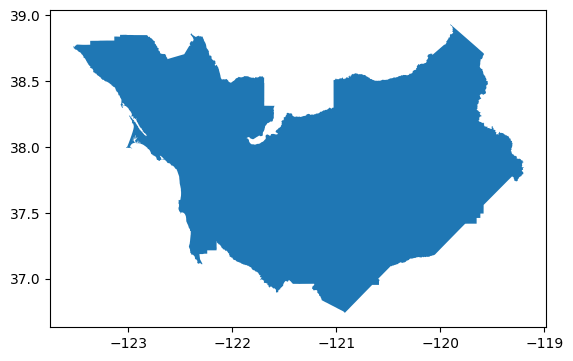

In [42]:
test.plot()

In [17]:
def breakout_districts2(provider, gcs_file_path:str, file_name:str):
    # Load geojson 
    caltrans_shape = "https://gis.data.ca.gov/datasets/0144574f750f4ccc88749004aca6eb0c_0.geojson?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
    ct_districts = to_snakecase(gpd.read_file(f'{caltrans_shape}')
               .to_crs(epsg=4326))[['district','geometry']]
    
    # Districts: subset
    district_list = [10,4]
    
    full_gdf = pd.DataFrame()

    for i in district_list:
        district_gdf = ct_districts[ct_districts.district==i]
        
        district_gdf_clipped = utilities.find_difference_and_clip(provider, district_gdf) 
        full_gdf = pd.concat([full_gdf, district_gdf_clipped], axis=0)
        
    full_gdf = full_gdf.dissolve().drop(columns = ['district'])
    
    utils.geoparquet_gcs_export(full_gdf, gcs_file_path,file_name) 
    return full_gdf

In [18]:
my_gdf = breakout_districts2(att, GCS_FILE_PATH, 'att_d10_d4')

<AxesSubplot:>

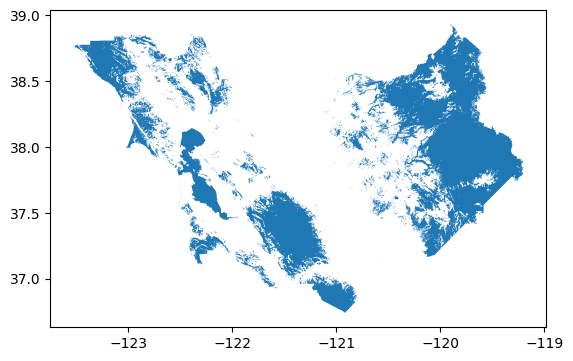

In [19]:
my_gdf.plot()

In [20]:
routes_df = utilities.load_unique_routes_df()

In [22]:
o1 = gpd.overlay(routes_df, my_gdf, how="intersection")

In [24]:
o1 = o1.assign(
        overlay_route_length=o1.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

In [33]:
# Calculate the length of the intersected geometry 
o1['percentage_route_length'] = o1['overlay_route_length']/o1['original_route_length']
# Subtract percentage of length to find portion of route that IS covered by provider'
o1['percentage_covered_by_provider'] = (1 - o1['percentage_route_length'])*100

In [38]:
# Filter based on median
low_coverage = o1[(o1.percentage_covered_by_provider < 81)]

## Go through several counties

In [ ]:
# Grab all counties in SF 
ca_counties_list = ca_counties.county_name.unique().tolist()

In [ ]:
# Subset
ca_counties_list = ['Alameda','San_Francisco','Los_Angeles', 'Placer', 'Mariposa']

In [ ]:
# Filter ca_counties gdf for each county 
for i in ca_counties_list:
    exec(f"{i}_gdf = ca_counties[ca_counties['county_name']== i].reset_index(drop=True)")

In [ ]:
# Create a list to hold each dataframe 
string = '_gdf'
counties_gdf_list = [x + string for x in ca_counties_list]

In [ ]:
# Apply function to each gdf
for county in counties_gdf_list:
    exec(f"{county} = (utilities.find_difference_and_clip(att, {county}))")

In [ ]:
# Compare LA with debug_ah.ipynb results
# Blue are areas that are in LA County but aren't covered by AT&T
# This is accurate
Los_Angeles_gdf.plot()

In [ ]:
# Remove quotes from list, since these aren't strings. They are dataframes. 
counties_gdf_list = [Alameda_gdf, San_Francisco_gdf, Los_Angeles_gdf, Placer_gdf, Mariposa_gdf]

In [ ]:
# Concat using dask 
# https://github.com/cal-itp/data-analyses/blob/main/_shared_utils/shared_utils/gtfs_utils.py#L563-L564
att_concat = dd.multi.concat(counties_gdf_list, axis=0)

In [ ]:
# https://dask-geopandas.readthedocs.io/en/stable/docs/reference/api/dask_geopandas.GeoDataFrame.dissolve.html
att_concat.dissolve(split_out=1)

In [ ]:
att_concat_gpd = att_concat.compute()

In [ ]:
att_concat_gpd = att_concat_gpd.dissolve().drop(columns = ['county_name'])

In [ ]:
att_concat_gpd.plot()

In [ ]:
routes_df = utilities.load_unique_routes_df()

In [ ]:
# TopologyException: side location conflict at -118.658061 34.07038. This can occur if the input geometry is invalid.

In [ ]:
# o1 = gpd.overlay(routes_df, att_concat_gpd, how="intersection")

### Testing with subset

In [ ]:
counties_wanted = ['San_Francisco','Los_Angeles','San_Mateo', 'Placer', 'Mariposa']
# Subset to a few counties
ca_subset = ca_counties[ca_counties["county_name"].isin(counties_wanted)]

In [ ]:
test = utilities.find_difference_and_clip(att, ca_subset)

In [ ]:
test = test.dissolve().drop(columns = ['county_name'])

In [ ]:
test == att_concat_gpd

In [ ]:
test.plot()

In [ ]:
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
    "Roseville Transit"
]

routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "None"
]


def subset_routes(agency_wanted, routes_wanted):
    # Filter out
    routes_subset = routes_df[
        routes_df["route_name"].isin(routes_wanted)
        & routes_df["agency"].isin(agency_wanted)
    ]
    return routes_subset


routes_subset = subset_routes(agency_wanted, routes_wanted)

In [ ]:
o2 = gpd.overlay(routes_subset, test, how="intersection")

In [ ]:
o2 = o2.assign(
        overlay_route_length=o2.geometry.to_crs(geography_utils.CA_StatePlane).length
    )

In [ ]:
# Calculate the length of the intersected geometry 
o2['percentage_route_length'] = o2['overlay_route_length']/o2['original_route_length']
# Subtract percentage of length to find portion of route that IS covered by provider'
o2['percentage_covered_by_provider'] = 1 - o2['percentage_route_length']

In [ ]:
# Subtract percentage of length to find portion of route that IS covered by provider'
o2['percentage_covered_by_provider'] = 1 - o2['percentage_route_length']

In [ ]:
o2